# Projet Py - Logements

### import des biblios

In [1]:
import numpy as np
import pandas as pd
import glob
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd # pip install geopandas
import pysal as ps # conda install -c anaconda pysal= 2.1
import scipy
from scipy.spatial import KDTree
import contextily as cx
import plotly.express as px
from libpysal.weights import W
import matplotlib.colors as colors

C:\Users\Thomas\Anaconda3\envs\spatial\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\Thomas\Anaconda3\envs\spatial\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Thomas\Anaconda3\envs\spatial\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## functions

In [2]:
def com_code(code, dep):
    if len(str(code))==1:
        code="00"+str(code)
    if len(str(code))==2:
        code="0"+str(code)
    code=str(dep)+ str(code)
    return code


### Problématique 
Où construit-on le plus en France?

Pour répondre à cette question, trois échelles ont été étudiées:

-régionale

-départementales

-et une étude de cas plus précise pour le département qui a été identifié comme celui où on construit le plus: loire-atlantique

### Données utilisées
Les données utilisées sont issues de la base de données sitadel qui recense tout les projets de construction en France, elle est mise à dispostion sous la forme d'un fichier csv.
Nous avons décider de nous baser sur l'année 2021.



In [3]:
sitadel=pd.read_csv('PC_DP_créant_logements_2021.txt', sep='\t', encoding='latin-1', low_memory=False)

In [4]:
sitadel.head()

REG DEP  COMM Type_DAU        Num_DAU  Etat_DAU DATE_REELLE_AUTORISATION  \
0   82   1  1001       PC  00100120V0010         2               18/01/2021   
1   82   1  1001       PC  00100121V0001         5               16/03/2021   
2   82   1  1001       PC  00100121V0002         2               02/04/2021   
3   82   1  1001       PC  00100121V0003         2               26/04/2021   
4   82   1  1001       PC  00100121V0004         5               12/05/2021   

  DATE_REELLE_DOC DATE_REELLE_DAACT  DPC_AUT  ... SURF_HAB_AVANT  \
0             NaN               NaN   202101  ...            0.0   
1      28/06/2021               NaN   202103  ...            0.0   
2             NaN               NaN   202104  ...            0.0   
3             NaN               NaN   202104  ...            0.0   
4      25/11/2021               NaN   202105  ...            0.0   

   SURF_HAB_CREEE  SURF_HAB_ISSUE_TRANSFO SURF_HAB_DEMOLIE  \
0            92.0                     0.0              0.0   
1           112.0                     0.0              0.0   
2             0.0                   142.0              0.0   
3           105.0                     0.0              0.0   
4           103.0                     0.0              0.0   

  SURF_HAB_TRANSFORMEE SURF_LOC_AVANT SURF_LOC_CREEE SURF_LOC_ISSUE_TRANSFO  \
0                  0.0              0              0                      0   
1                  0.0              0              0                      0   
2                  0.0            142              0                      0   
3                  0.0              0              0                      0   
4                  0.0              0              0                      0   

  SURF_LOC_DEMOLIE SURF_LOC_TRANSFORMEE  
0                0                    0  
1                0                    0  
2                0                  142  
3                0                    0  
4                0                    0  

[5 rows x 67 columns]

## Partie 1: Echelle Regionale 

### Group by region
Puis nous avons regroupé les données par région pour une comparaison à l'échelle régionale

In [5]:
reg_sitadel=sitadel[['REG', 'Num_DAU']].groupby(['REG'], as_index=False).count()

In [6]:
reg_sitadel['REG']=reg_sitadel['REG'].apply(str)

In [7]:
reg_sitadel['REG']=reg_sitadel['REG'].replace({'1': 'Guadeloupe', '2': 'Martinique', '3': 'Guyane', '4': 'La Reunion','6':'Mayotte', 
                         '11': 'Ile-de-France', '21': 'Grand Est','22': 'Haut-de-France', '23':'Normandie', 
                         '24':'Centre-Val-de-Loire','25': 'Normandie', '26':'Bourgogne-France-Comté', 
                         '31': 'Haut-de-France','41':'Grand Est', '42': 'Grand Est',
                         '43':'Bourgogne-France-Comté', '52': 'Pays de la Loire', '53':'Bretagne',
                        '54':'Nouvelle-Aquitaine', '72':'Nouvelle-Aquitaine', '73':'Occitanie',
                        '74':'Nouvelle-Aquitaine', '82':'Auvergne-Rhone-Alpes', '83':'Auvergne-Rhone-Alpes',
                        '91': 'Occitanie', '93':'Rhone-Alpes-Cote-Azur', '94': 'Corse'})

In [8]:
reg_sitadel=reg_sitadel[['REG', 'Num_DAU']].groupby(['REG'], as_index=False).sum()

In [9]:
reg_sitadel=reg_sitadel.sort_values(by=['Num_DAU'], ascending=True)

In [10]:
fig = px.bar(reg_sitadel, x='REG', y='Num_DAU',  color='REG',
             title="Nombre de nouvelles constructions par région en France en 2021",
             width=1200, height=800,
            labels={
                     "Num_DAU": "Nombre de construction",
                     "REG": "Régions",
                 })



In [11]:
##fig.show()

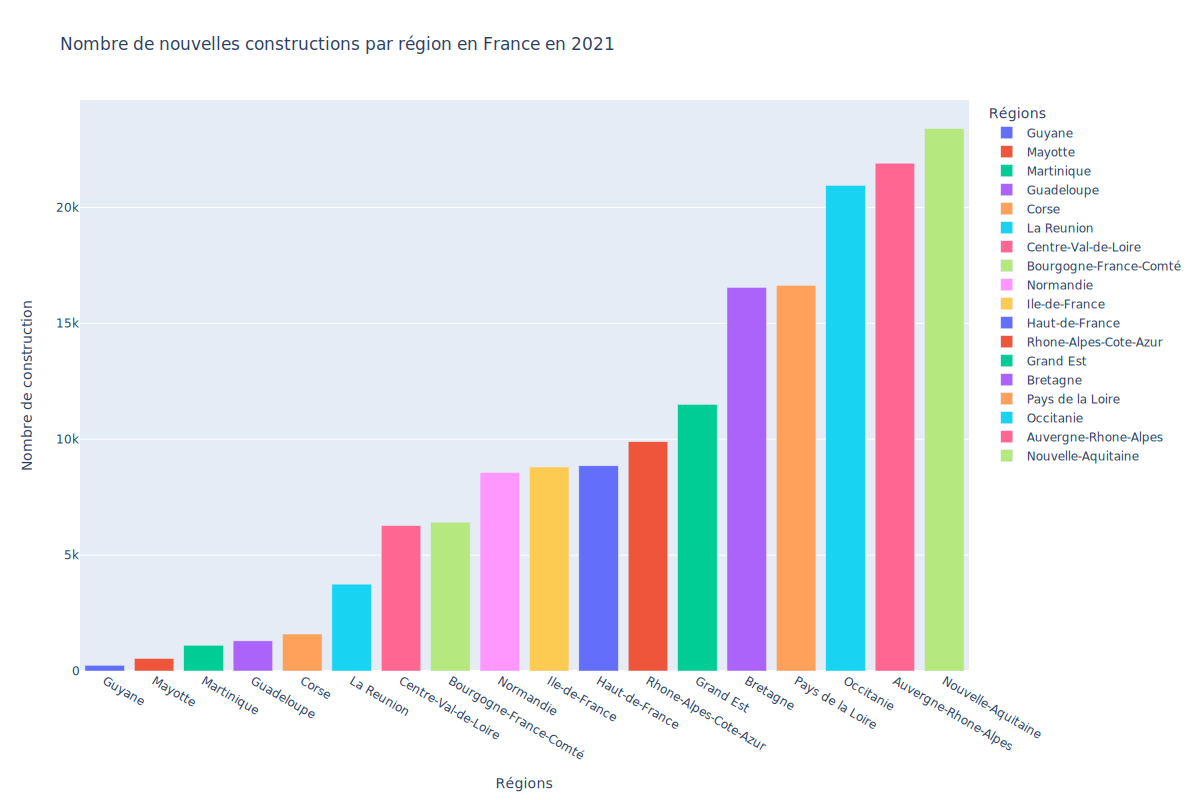

In [12]:
fig.show(renderer="svg")

## Partie 2: Echelle Departementale




### Count par nombre de demandes de permis de construire par départements

In [13]:
departement_sitadel=sitadel[['DEP', 'Num_DAU']].groupby(['DEP'], as_index=False).count()

In [14]:
dep_top=departement_sitadel.sort_values(by=['Num_DAU'], ascending=False).head(10)

In [15]:
dep_top['rank']=dep_top['Num_DAU'].rank(ascending=False, method='min')

In [16]:
dep_top

DEP  Num_DAU  rank
39   44     6008   1.0
84   85     5820   2.0
27   33     5716   3.0
52   56     4737   4.0
29   35     4437   5.0
20   29     4302   6.0
8    17     4041   7.0
25   31     3963   8.0
28   34     3769   9.0
99  974     3748  10.0

In [17]:
dep_top10=dep_top['DEP'].tolist()

### Creation d'une liste contenant le top 10 des départements où résident le plus de demandeur de permis de construire

In [18]:
sitadel_part=sitadel[sitadel['CAT_DEM'].isin([10,11])].copy()

In [19]:
len(sitadel_part)/len(sitadel)

0.8648834915693288

In [20]:
sitadel_part['DEP_D']=sitadel_part.CODPOST_DEM.str[:2]

In [21]:
dep_origine=sitadel_part[['DEP', 'DEP_D', 'Num_DAU']].groupby(['DEP','DEP_D'], as_index=False).count()

In [22]:
dep_origine=dep_origine[dep_origine['DEP'].isin(dep_top10)]

In [23]:
dep_origine

DEP DEP_D  Num_DAU
311    17             30
312    17    10        2
313    17    11        2
314    17    12        1
315    17    13        4
...   ...   ...      ...
3793  974    94        4
3794  974    97     3210
3795  974    98        1
3796  974    SA        1
3797  974    Sa        1

[662 rows x 3 columns]

In [24]:
dep_origine['DEP_D']=np.where(dep_origine['DEP']==dep_origine['DEP_D'], 'venant du departement', dep_origine['DEP_D'])
dep_origine['DEP_D']=np.where((dep_origine['DEP']=='974') & (dep_origine['DEP_D']=='97'), 'venant du departement', dep_origine['DEP_D'])

In [25]:
dep_origine['DEP_D']=np.where(dep_origine['DEP_D']=='venant du departement', dep_origine['DEP_D'], 'autres')

In [26]:
##dep_origine.sort_values(by=['Num_DAU'], ascending=[False]).head(11)

In [27]:
##dep_origine['rank']=dep_origine['DEP'].map(dep_top.set_index('DEP')['rank'])

In [28]:
##dep_origine=dep_origine.sort_values(by=['rank'], ascending=False)

In [29]:
dep_origine=dep_origine[['DEP', 'DEP_D', 'Num_DAU']].groupby(['DEP','DEP_D'], as_index=False).sum()

In [30]:
dep_origine['rank']=dep_origine['DEP'].map(dep_top.set_index('DEP')['rank'])
dep_origine=dep_origine.sort_values(by=['rank','DEP_D'], ascending=[False,True])

In [31]:
fig = px.bar(dep_origine, x="DEP", y="Num_DAU", color="DEP_D", 
             title="Nombre de nouvelles constructions dans les 10 départements où on construit le plus en France en 2021",
            width=1000, height=600,
            labels={
                     "Num_DAU": "Nombre de construction",
                     "DEP": "Numéro du département",
                     "DEP_D": "Originie du propriétaire"
                 },
            color_discrete_map={
        'autres': '#696969',
        'venant du departement': '#6495ED'})

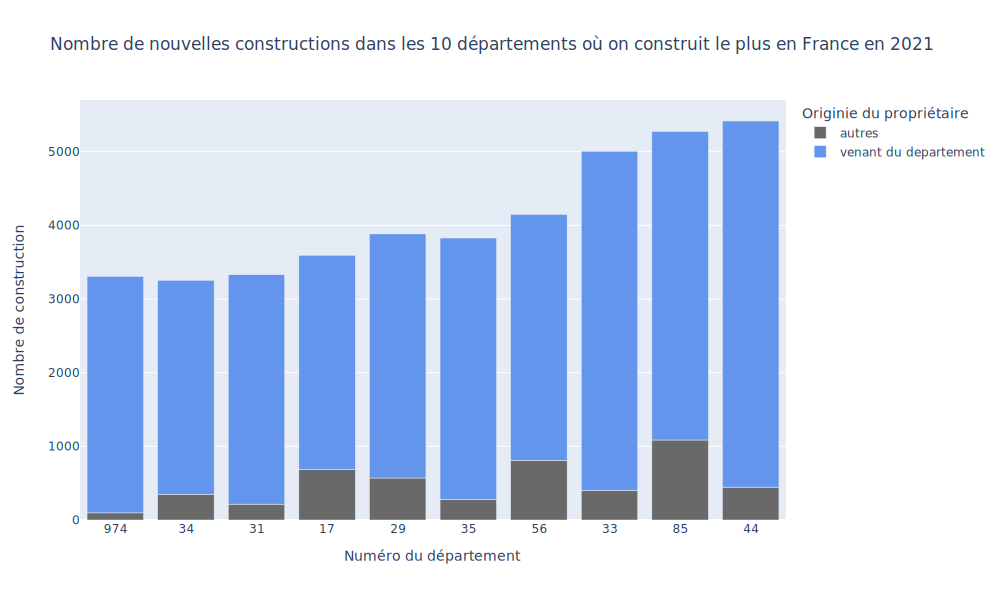

In [32]:
fig.show(renderer="svg")


## Partie 3: Etude de cas extension urbaine en Loire-Atlantique


### Création d'un Geodataframe

In [33]:
dep_44=gpd.read_file(r'communes-loire-atlantique.geojson')


In [34]:
dep_44

code_insee  st_length_shape      libelle_long_norm  arr_dep_libelle_majus  \
0        44180     92872.116836     Vallons de l'Erdre  CHATEAUBRIANT ANCENIS   
1        44163     37073.627662         Vair sur Loire  CHATEAUBRIANT ANCENIS   
2        44001     36616.145426               Abbaretz  CHATEAUBRIANT ANCENIS   
3        44015     54731.352317                  Blain  CHATEAUBRIANT ANCENIS   
4        44019     23286.250723                  Bouee          SAINT NAZAIRE   
..         ...              ...                    ...                    ...   
202      44197     39461.966152         Sion les Mines  CHATEAUBRIANT ANCENIS   
203      44200     18254.718450              Soulvache  CHATEAUBRIANT ANCENIS   
204      44055     29219.246932     La Baule Escoublac          SAINT NAZAIRE   
205      44161     29656.445966  Saint Gildas des Bois          SAINT NAZAIRE   
206      44122     23446.254783             Petit Mars  CHATEAUBRIANT ANCENIS   

                                     epci_fisc_libelle      dept_libelle  \
0                                 CC du Pays d'Ancenis  Loire-Atlantique   
1                                 CC du Pays d'Ancenis  Loire-Atlantique   
2                                          CC de Nozay  Loire-Atlantique   
3                             CC de la Région de Blain  Loire-Atlantique   
4                                CC Estuaire et Sillon  Loire-Atlantique   
..                                                 ...               ...   
202                            CC Châteaubriant-Derval  Loire-Atlantique   
203                            CC Châteaubriant-Derval  Loire-Atlantique   
204  CA de la Presqu'île de Guérande Atlantique (Ca...  Loire-Atlantique   
205    CC du Pays de Pontchâteau Saint-Gildas-des-Bois  Loire-Atlantique   
206                              CC d'Erdre et Gesvres  Loire-Atlantique   

             libelle_majus type_comm_libelle  article_code  \
0       VALLONS DE L ERDRE  commune actuelle             0   
1           VAIR SUR LOIRE  commune actuelle             0   
2                 ABBARETZ  commune actuelle             1   
3                    BLAIN  commune actuelle             0   
4                    BOUEE  commune actuelle             0   
..                     ...               ...           ...   
202         SION LES MINES  commune actuelle             0   
203              SOULVACHE  commune actuelle             0   
204        BAULE ESCOUBLAC  commune actuelle             3   
205  SAINT GILDAS DES BOIS  commune actuelle             0   
206             PETIT MARS  commune actuelle             0   

           arr_dep_libelle article_charniere epci_fisc_siren dept_code  \
0    Châteaubriant-Ancenis                de       244400552        44   
1    Châteaubriant-Ancenis                de       244400552        44   
2    Châteaubriant-Ancenis                d'       244400537        44   
3    Châteaubriant-Ancenis                de       244400453        44   
4            Saint-Nazaire                de       200072734        44   
..                     ...               ...             ...       ...   
202  Châteaubriant-Ancenis                de       200072726        44   
203  Châteaubriant-Ancenis                de       200072726        44   
204          Saint-Nazaire             de La       244400610        44   
205          Saint-Nazaire                de       200000438        44   
206  Châteaubriant-Ancenis                de       244400503        44   

    dept_libelle_majus arr_dep_code_insee  \
0     LOIRE ATLANTIQUE                445   
1     LOIRE ATLANTIQUE                445   
2     LOIRE ATLANTIQUE                445   
3     LOIRE ATLANTIQUE                445   
4     LOIRE ATLANTIQUE                443   
..                 ...                ...   
202   LOIRE ATLANTIQUE                445   
203   LOIRE ATLANTIQUE                445   
204   LOIRE ATLANTIQUE                443   
205   LOIRE ATLANTIQUE            

In [35]:
dep_44['geometry']=dep_44['geometry'].simplify(0.001)

### nombre de constructions par commune

In [36]:
com_sitadel=sitadel[['COMM', 'Num_DAU']].groupby(['COMM'], as_index=False).count()
##dep_sitadel01 = dep_sitadel01[dep_sitadel01['COMM'].str.startswith('01')] 

### jointure pour cartographie

In [37]:
dep_44=dep_44.merge( com_sitadel, left_on='code_insee', right_on='COMM', how='left')
dep_44['Num_DAU'] = dep_44['Num_DAU'].fillna(0)

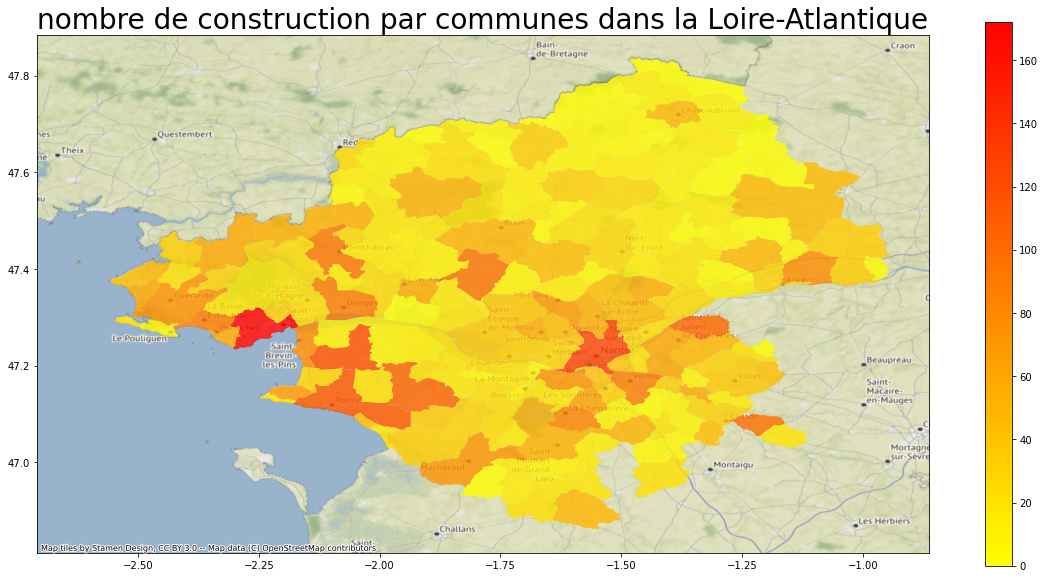

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax=dep_44.plot(ax=ax, column='Num_DAU',  cmap='autumn_r', legend=True, alpha=0.8,  legend_kwds={'shrink': 0.5})
plt.title("nombre de construction par communes dans la Loire-Atlantique", fontdict={'fontsize': 28, 'fontweight': 'medium'} )
cx.add_basemap(ax, crs=dep_44.crs)


In [39]:
dep_44.index=dep_44.libelle_long_norm
dep_44.index= dep_44.index.rename('commune')

### Nombre de nouvelles construction par nombre d'habitant

In [40]:
recensement_44=pd.read_csv('recensement_44_2022.csv', sep=';')

In [41]:
recensement_44['code_com']=recensement_44['Code commune'].apply(lambda x: com_code(x, 44))

In [42]:
dep_44=dep_44.merge( recensement_44, left_on='code_insee', right_on='code_com', how='left')

In [43]:
dep_44['con_by_h']=dep_44['Num_DAU']/dep_44['Population totale']*100

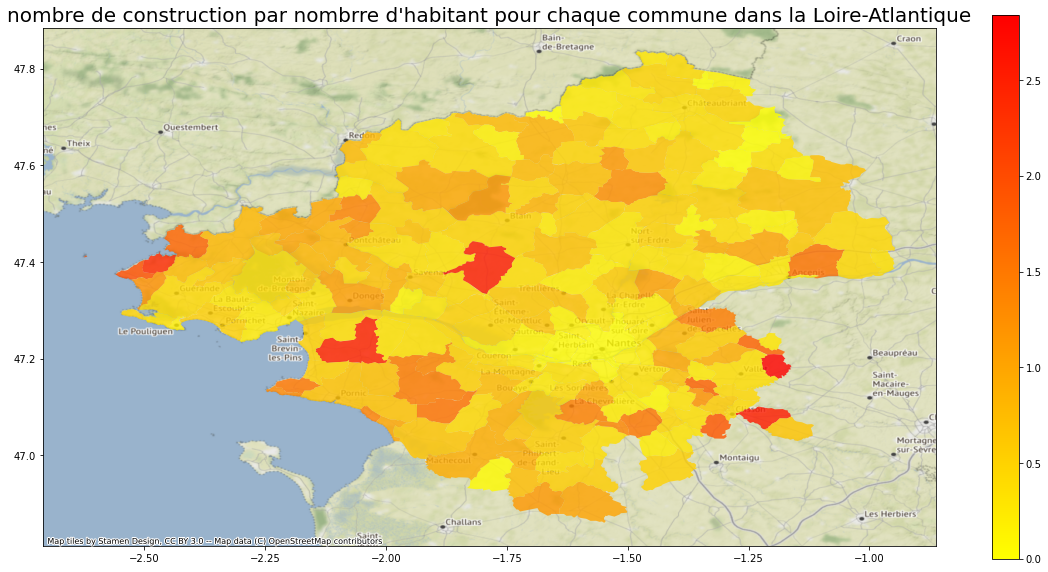

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax=dep_44.plot(ax=ax, column='con_by_h',  cmap='autumn_r', legend=True, alpha=0.8,  legend_kwds={'shrink': 0.5})
plt.title("nombre de construction par nombrre d'habitant pour chaque commune dans la Loire-Atlantique", fontdict={'fontsize': 20, 'fontweight': 'medium'})
cx.add_basemap(ax, crs=dep_44.crs)

Il est difficile de tirer une conclusion et d'extraire des dynamiques territoriales avec une approche quantitative.
Nous allons donc utiliser l'indice de Moran local qui permet d'identifier les zones de cluster.
La démarche que nous allons suivre est tirée de deux sources:

-cette article de l'insee: https://www.insee.fr/fr/statistiques/fichier/3635442/imet131-g-chapitre-3.pdf

-et cette conférence D'Anselin, fondateur de l'économétrie spatiale: https://www.youtube.com/watch?v=d1WJNBwXfgo&list=PLzREt6r1Nenkr2vtYgbP4hs44HO_s_qEO&index=4


### indice de moran
<br>
### variable étudiée

#### preparation des donnees

In [45]:
dep_44=dep_44.to_crs('EPSG:2154')

In [46]:
y=dep_44['Num_DAU']

In [47]:
o=ps.lib.weights.KNN.from_dataframe(dep_44, geom_col='geometry', k=10)
    

### calcul indice de moran global

In [48]:
m=ps.explore.esda.Moran(y, o, transformation='r')

### indice de moran global 

In [49]:
print('moran global')
print(m.I)

moran global
0.1597764841542399


### Indice de moran local

In [50]:
o

In [51]:
m_local=ps.explore.esda.Moran_Local(y,o, permutations=100000)

## valeurs locales de Moran

In [52]:
dep_44['index_moran_classe']=m_local.q
dep_44['index_moran']=m_local.Is

### test de l'hypothèse de randomisation 

In [53]:
if m.p_rand < 0.05:
    print('H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale')
    ##indique les clusters avec q la classe et p_sim la p_value
    dep_44['p_value']= m_local.p_sim
else :
    print('H0 est accepté, il y a randomisation donc il n y a pas autocorrelation globale')
    ##suit une loi normal
    dep_44['p_value']= m_local.p_z_sim*2

H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale


### False Discovery Rate

In [54]:
test=ps.explore.esda.fdr(dep_44['p_value'], 0.10)
dep_44['index_moran_cluster']=dep_44['index_moran_classe'].where(dep_44['p_value'] <= test).fillna(0)

### Cartographie des Clusters
(HH: high high, HL: High Low, LH: Low Hig, LL: Low Low)

In [55]:
maskHH= dep_44['index_moran_cluster'] ==np.intc(1.0)
maskLH= dep_44['index_moran_cluster'] ==np.intc(2.0)
maskLL= dep_44['index_moran_cluster'] ==np.intc(3.0)
maskHL= dep_44['index_moran_cluster'] ==np.intc(4.0)
maskother= dep_44['index_moran_cluster'] ==np.intc(0.0)

In [56]:
dep_44['index_moran_cluster']=dep_44['index_moran_cluster'].mask(maskHH, 'HH')
dep_44['index_moran_cluster']=dep_44['index_moran_cluster'].mask(maskLH, 'LH')
dep_44['index_moran_cluster']=dep_44['index_moran_cluster'].mask(maskLL, 'LL')
dep_44['index_moran_cluster']=dep_44['index_moran_cluster'].mask(maskHL, 'HL')
dep_44['index_moran_cluster']=dep_44['index_moran_cluster'].mask(maskother, 'non_significant')
dep_44['index_moran_cluster']



0                   HL
1      non_significant
2                   LL
3      non_significant
4      non_significant
            ...       
202                 LL
203                 LL
204                 HH
205    non_significant
206    non_significant
Name: index_moran_cluster, Length: 207, dtype: object

In [57]:
color_dict = {'LL':'#b82e2e', 'LH':'#FC6955', 'HL':'#3283FE', 
              'HH':'#1223e0', 'non_significant':'#bab0ac'}

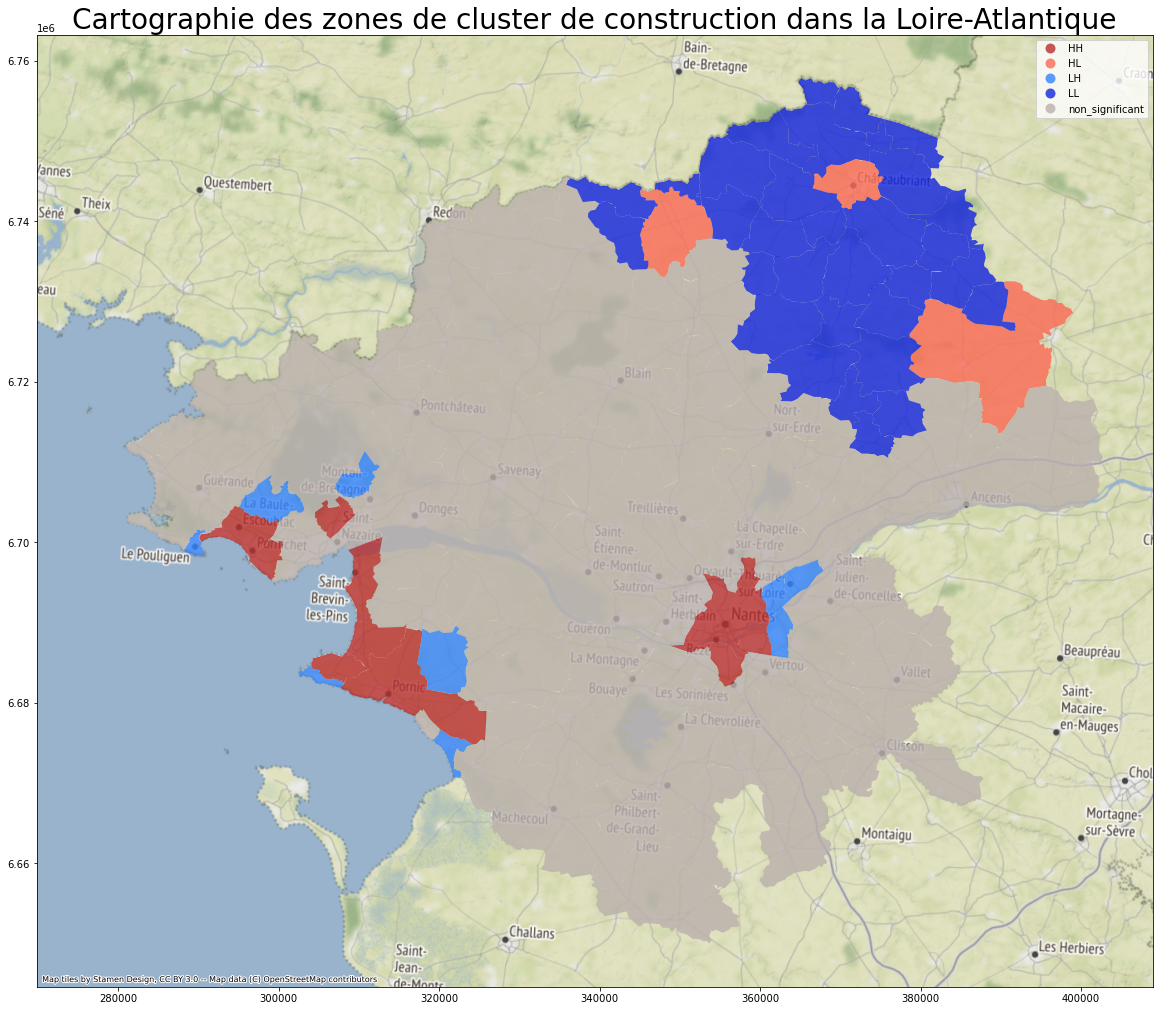

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax=dep_44.plot(ax=ax,column='index_moran_cluster',legend=True,alpha=0.8, legend_kwds={ 'bbox_to_anchor': (1, 1)},
              cmap=colors.ListedColormap(list(color_dict.values())))
plt.title("Cartographie des zones de cluster de construction dans la Loire-Atlantique", fontdict={'fontsize': 28, 'fontweight': 'medium'})
cx.add_basemap(ax, crs=dep_44.crs)


## Adding Vendee in the analysis

### data structuration

In [59]:
dep_85=gpd.read_file(r'communes-17-charente-maritime.geojson')
dep_85=dep_85[['com_code', 'com_name', 'geometry' ]].copy()
dep_85=dep_85.rename(columns={'com_code':'code', 'com_name':'nom'})
dep_85=dep_85.to_crs('EPSG:2154')


In [60]:
dep_44=dep_44[['code_insee', 'libelle_long_norm', 'geometry']].copy()
dep_44=dep_44.rename(columns={'code_insee':'code', 'libelle_long_norm':'nom'})

In [61]:
dep_44_85=pd.concat([dep_44, dep_85])

In [62]:
dep_44_85=dep_44_85.merge( com_sitadel, left_on='code', right_on='COMM', how='left')
dep_44_85['Num_DAU'] = dep_44_85['Num_DAU'].fillna(0)

In [63]:
recensement_44=pd.read_csv('recensement_44_2022.csv', sep=';')
recensement_44['code_com']=recensement_44['Code commune'].apply(lambda x: com_code(x, 44))
recensement_85=pd.read_csv('recensement_85_2022.csv', sep=';')
recensement_85['code_com']=recensement_85['Code commune'].apply(lambda x: com_code(x, 85))



recensement_44_85=pd.concat([recensement_44, recensement_85])

In [64]:
dep_44_85=dep_44_85.merge( recensement_44_85, left_on='code', right_on='code_com', how='left')

### Moran Index with KNN matrix

In [65]:
y=dep_44_85['Num_DAU']

In [66]:
o=ps.lib.weights.KNN.from_dataframe(dep_44_85, geom_col='geometry', k=10)

In [67]:
m=ps.explore.esda.Moran(y, o)

#### global

In [68]:
print('moran global')
print(m.I)

moran global
0.23901009853574168


#### local

In [69]:
m_local=ps.explore.esda.Moran_Local(y,o, permutations=100000)

In [70]:
dep_44_85['index_moran_classe']=m_local.q
dep_44_85['index_moran']=m_local.Is

#### test de randomisation

In [71]:
if m.p_rand < 0.05:
    print('H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale')
    ##indique les clusters avec q la classe et p_sim la p_value
    dep_44_85['p_value']= m_local.p_sim
else :
    print('H0 est accepté, il y a randomisation donc il n y a pas autocorrelation globale')
    ##suit une loi normal
    dep_44_85['p_value']= m_local.p_z_sim*2

H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale


#### false discovery rate

In [72]:
test=ps.explore.esda.fdr(dep_44_85['p_value'], 0.10)
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_classe'].where(dep_44_85['p_value'] <= test).fillna(0)

#### cartographie cluster

In [73]:
maskHH= dep_44_85['index_moran_cluster'] ==np.intc(1.0)
maskLH= dep_44_85['index_moran_cluster'] ==np.intc(2.0)
maskLL= dep_44_85['index_moran_cluster'] ==np.intc(3.0)
maskHL= dep_44_85['index_moran_cluster'] ==np.intc(4.0)
maskother= dep_44_85['index_moran_cluster'] ==np.intc(0.0)

In [74]:
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_cluster'].mask(maskHH, 'HH')
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_cluster'].mask(maskLH, 'LH')
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_cluster'].mask(maskLL, 'LL')
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_cluster'].mask(maskHL, 'HL')
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_cluster'].mask(maskother, 'non_significant')
dep_44_85['index_moran_cluster']

0                   HL
1      non_significant
2      non_significant
3      non_significant
4      non_significant
            ...       
460                 LL
461                 LL
462                 LL
463                 LL
464                 LL
Name: index_moran_cluster, Length: 465, dtype: object

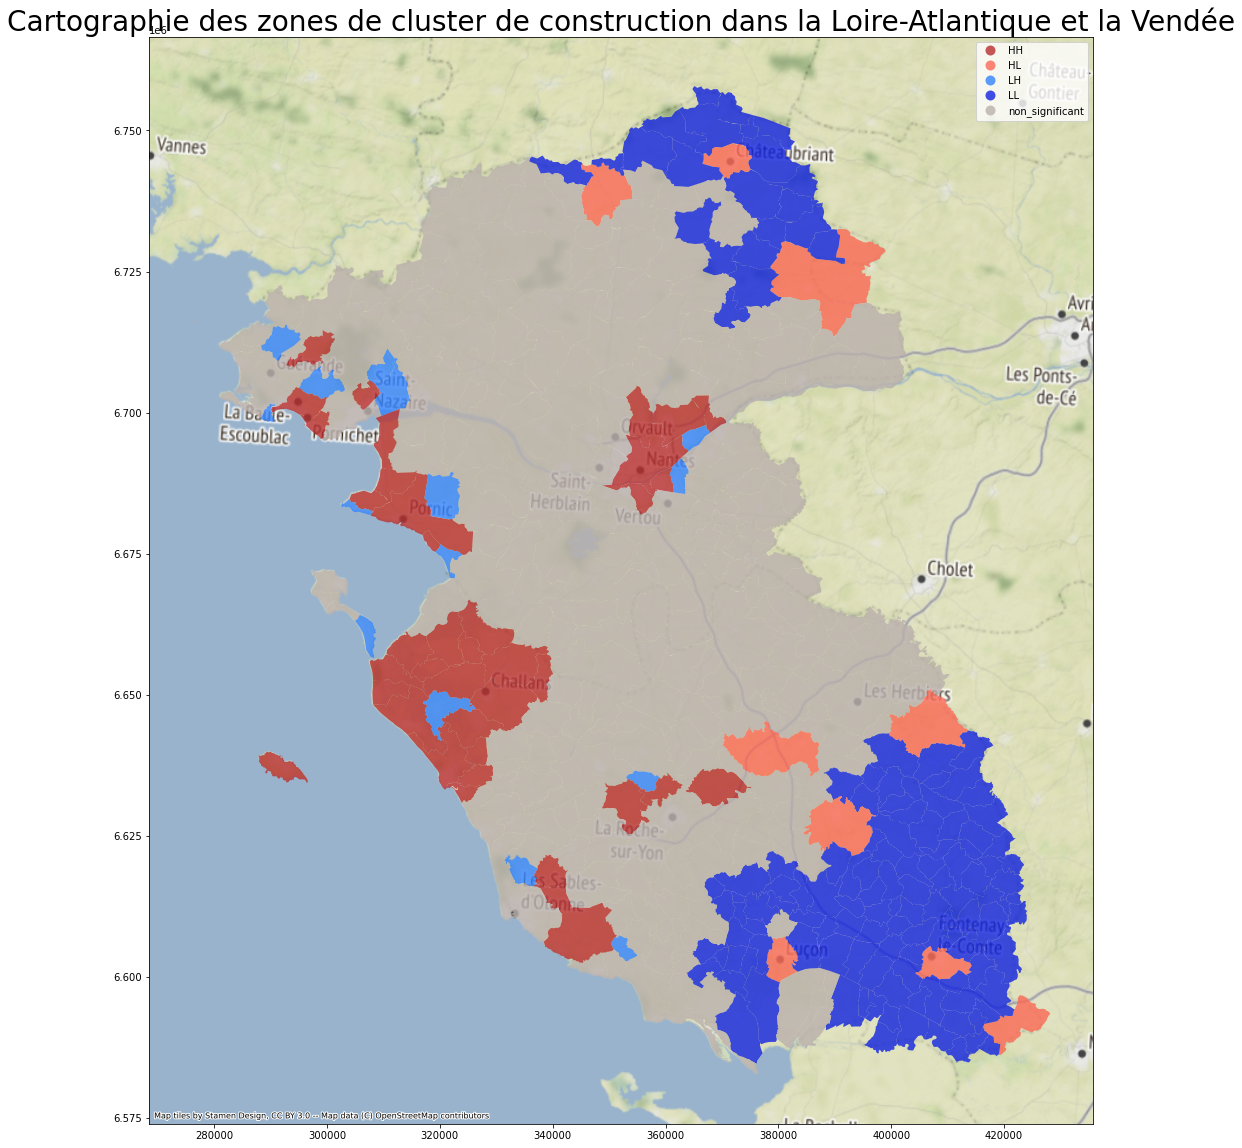

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax=dep_44_85.plot(ax=ax,column='index_moran_cluster',legend=True,alpha=0.8, legend_kwds={ 'bbox_to_anchor': (1, 1)},
              cmap=colors.ListedColormap(list(color_dict.values())))
plt.title("Cartographie des zones de cluster de construction dans la Loire-Atlantique et la Vendée", fontdict={'fontsize': 28, 'fontweight': 'medium'})
cx.add_basemap(ax, crs=dep_44_85.crs)

### Moran Index with contiguity matrix

In [76]:
o=ps.lib.weights.Queen.from_dataframe(dep_44_85, geom_col='geometry')

C:\Users\Thomas\Anaconda3\envs\spatial\lib\site-packages\pysal\lib\weights\contiguity.py:185: UserWarning:

There is one disconnected observation (no neighbors).
Island id: 390



In [77]:
m=ps.explore.esda.Moran(y, o)

('WARNING: ', 390, ' is an island (no neighbors)')


#### global

In [78]:
print('moran global')
print(m.I)

moran global
0.31893564630553195


#### local

In [79]:
m_local=ps.explore.esda.Moran_Local(y,o, permutations=100000)

In [80]:
dep_44_85['index_moran_classe']=m_local.q
dep_44_85['index_moran']=m_local.Is

#### test de randomisation

In [81]:
if m.p_rand < 0.05:
    print('H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale')
    ##indique les clusters avec q la classe et p_sim la p_value
    dep_44_85['p_value']= m_local.p_sim
else :
    print('H0 est accepté, il y a randomisation donc il n y a pas autocorrelation globale')
    ##suit une loi normal
    dep_44_85['p_value']= m_local.p_z_sim*2

H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale


#### false discovery rate

In [82]:
test=ps.explore.esda.fdr(dep_44_85['p_value'], 0.10)
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_classe'].where(dep_44_85['p_value'] <= test).fillna(0)

#### cartographie cluser

In [83]:
maskHH= dep_44_85['index_moran_cluster'] ==np.intc(1.0)
maskLH= dep_44_85['index_moran_cluster'] ==np.intc(2.0)
maskLL= dep_44_85['index_moran_cluster'] ==np.intc(3.0)
maskHL= dep_44_85['index_moran_cluster'] ==np.intc(4.0)
maskother= dep_44_85['index_moran_cluster'] ==np.intc(0.0)

In [84]:
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_cluster'].mask(maskHH, 'HH')
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_cluster'].mask(maskLH, 'LH')
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_cluster'].mask(maskLL, 'LL')
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_cluster'].mask(maskHL, 'HL')
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_cluster'].mask(maskother, 'non_significant')
dep_44_85['index_moran_cluster']

0                   HL
1      non_significant
2      non_significant
3      non_significant
4      non_significant
            ...       
460    non_significant
461    non_significant
462    non_significant
463                 LL
464    non_significant
Name: index_moran_cluster, Length: 465, dtype: object

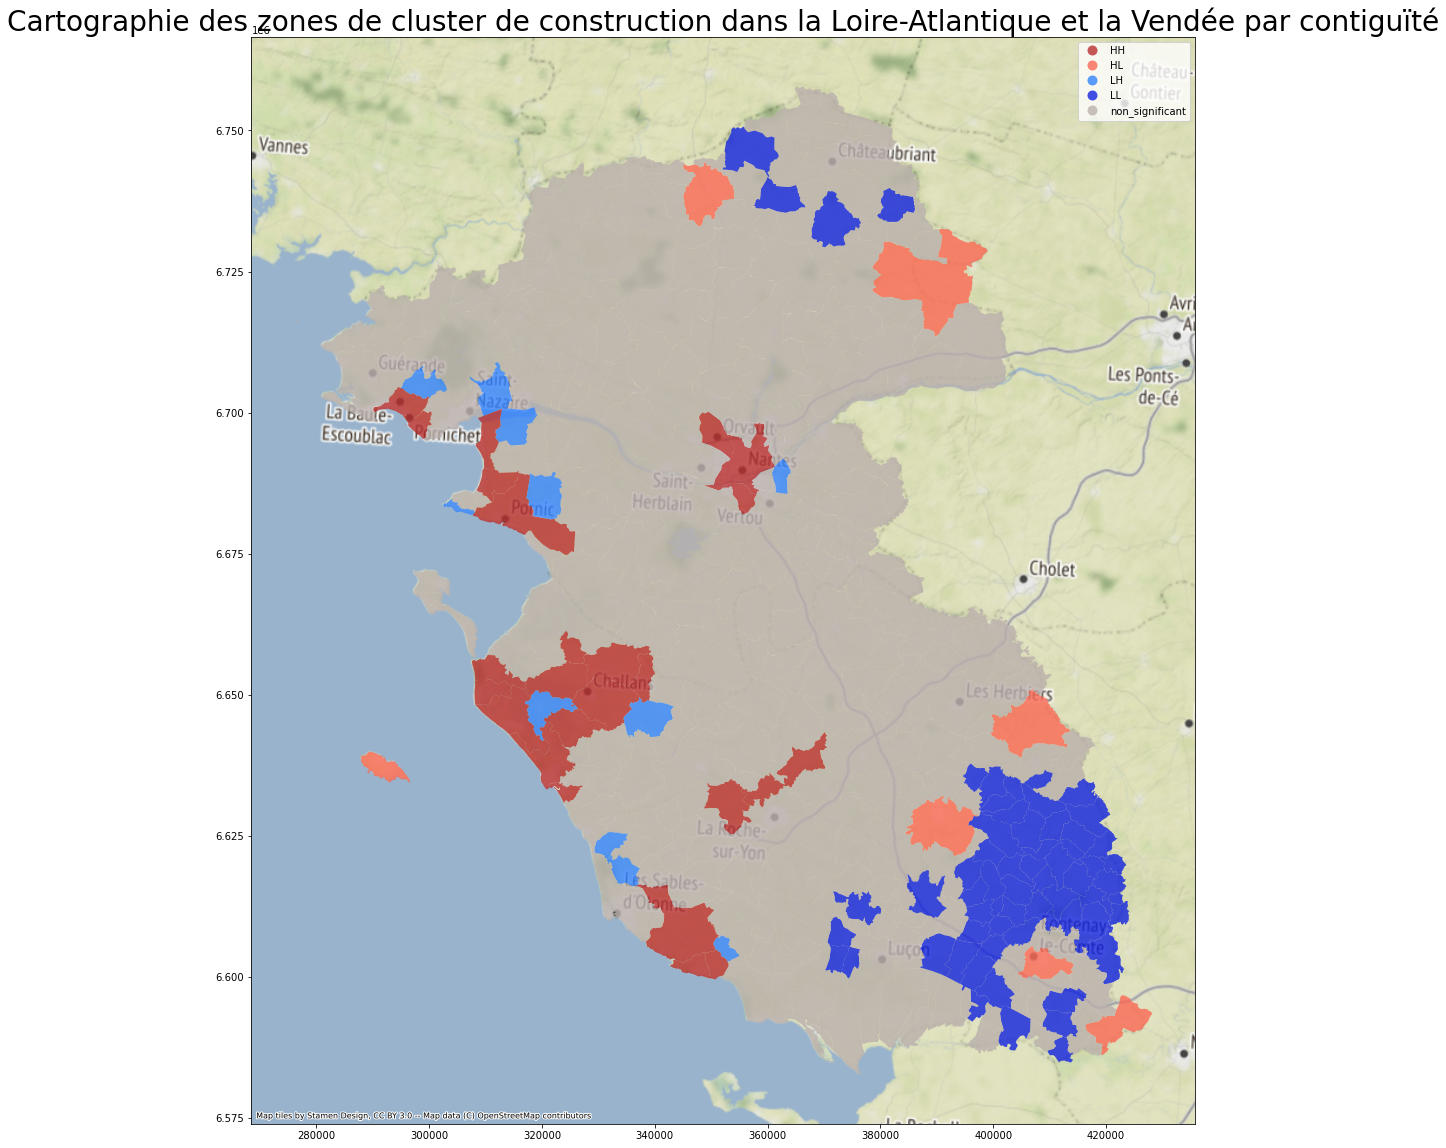

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax=dep_44_85.plot(ax=ax,column='index_moran_cluster',legend=True,alpha=0.8, legend_kwds={ 'bbox_to_anchor': (1, 1)},
              cmap=colors.ListedColormap(list(color_dict.values())))
plt.title("Cartographie des zones de cluster de construction dans la Loire-Atlantique et la Vendée par contiguïté", fontdict={'fontsize': 28, 'fontweight': 'medium'})
cx.add_basemap(ax, crs=dep_44_85.crs)

## En conclusion


## Discussion

Notre étude est limitée car elle prend uniquement en compte les constructions alors que l'étude de l'extension urbaine ne se réduit pas uniquement à ce prisme.
En effet beaucoup d'autres facteurs rentrent en compte: l'augmentation du prix du mètre carré, le type de construction (immeuble ou maison par exemple), l'évoultion sociologique des populations...